# Стратегия взаимодействия с пользователями сети фитнес-центров «Культурист-датасаентист»

  Распространённая проблема фитнес-клубов — отток клиентов. Клиенты перестают пользоваться сервисом.
Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Если клиент немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество анкет пользователей. Задача — провести анализ и подготовить план действий по удержанию клиентов.

### Загрузка данных

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
# data=pd.read_csv('/datasets/gym_churn.csv')

In [3]:
#посмотрим общую информацию
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


Текущие поля в датасете:

Данные пользователя за предыдущий до проверки факта оттока месяц:
- 'gender' — пол
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент  в таком случае фитнес-центр хранит информацию о работодателе клиента)
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
- 'Phone' — наличие контактного телефона
- 'Age' — возраст
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)
- 'Group_visits' — факт посещения групповых занятий
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

In [4]:
#приведем к нижнему регистру
data.columns = data.columns.str.lower()

In [5]:
#проверим на нули
data.isna().sum()

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

In [6]:
#посмотрим имеются ли дубликаты
data.duplicated().sum()

0

### Исследовательский анализ данных (EDA)

In [7]:
data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Учитывая средние значения и стандартное отклонение можно сказать, что в таблице присутствуют в равных колличествах как мужчины так и женщины, проживание или работа в районе, где находится фитнес-центр не более километра, средний возраст посетителей от 25 до 32, средняя частота посещений в неделю за все время с начала действия абонемента 1-3 раза в неделю.

In [8]:
data.groupby('churn').mean().T.style

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.74719,1.72856
group_visits,0.464103,0.268615
age,29.9765,26.9896
avg_additional_charges_total,158.446,115.083
month_to_end_contract,5.28309,1.66258


Неясно кто из таблицы гендера 0, а кто 1, но понятно что в принципе их 50\50, поэтому нет смысла их учитывать, есть различия в длительности текущего действующего абонемента,сроке до окончания текущего действующего абонемента, а также lifetime

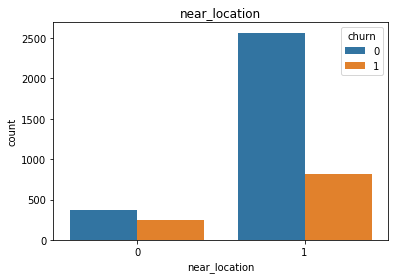

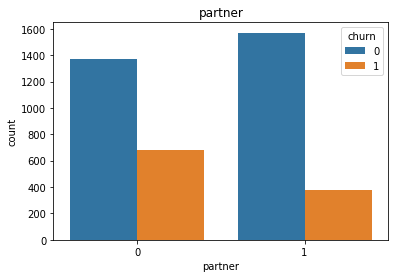

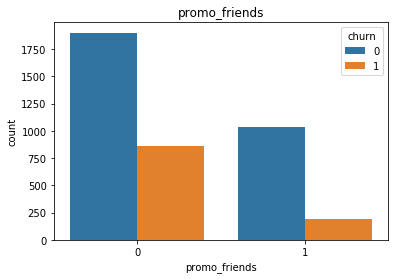

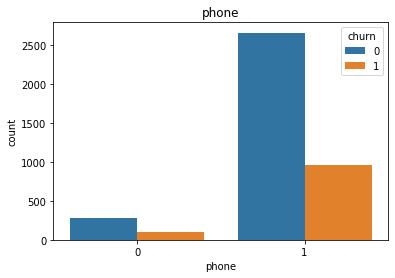

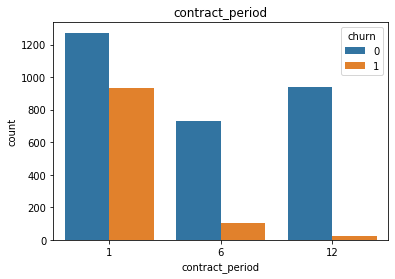

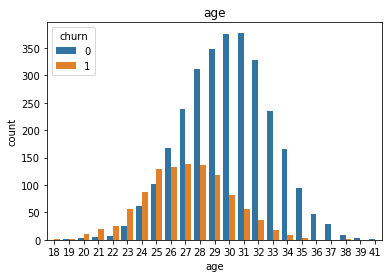

In [9]:
#Построим столбчатые гистограммы для основных параметров
list = ['near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'age']  # создаем список
for item in list:
    sns.countplot(x=data[item], hue='churn', data=data)
    plt.title(item)
    plt.show()

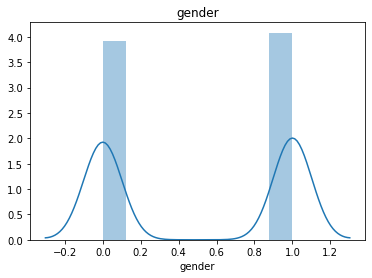

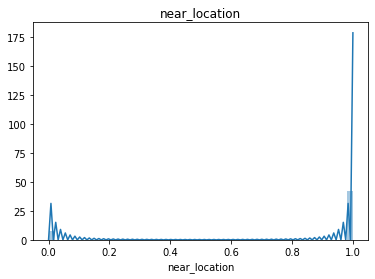

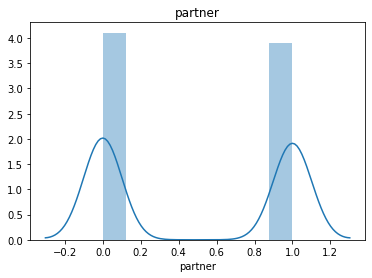

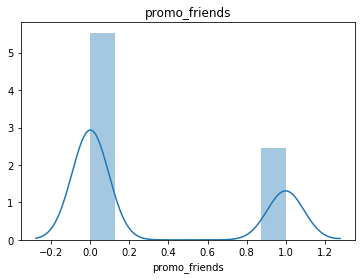

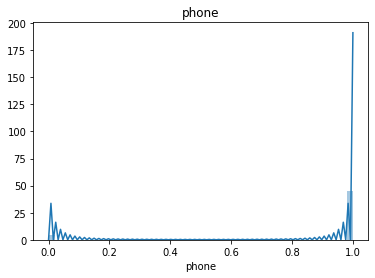

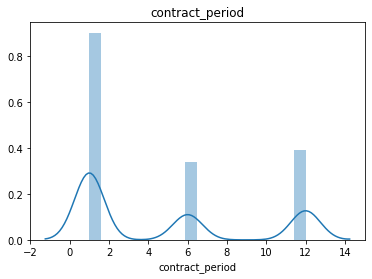

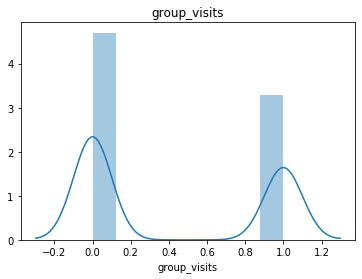

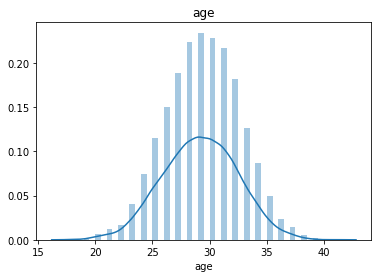

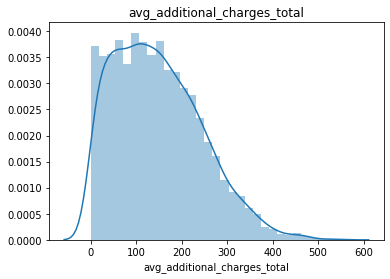

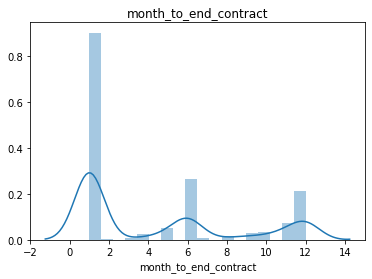

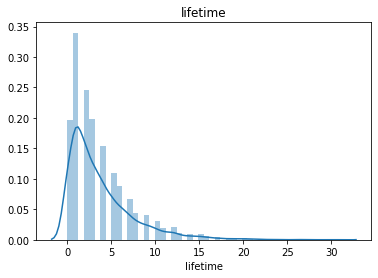

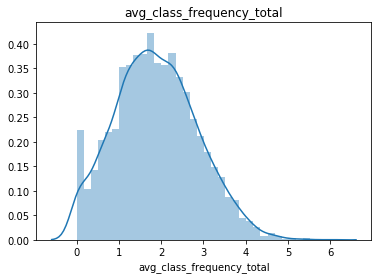

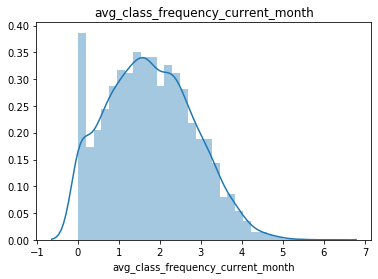

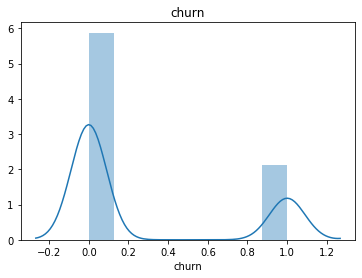

In [10]:
#распределения признаков
for column in data.columns:    
    data.groupby('churn')[column]
    sns.distplot(data[column])
    plt.title(column)
    plt.show()

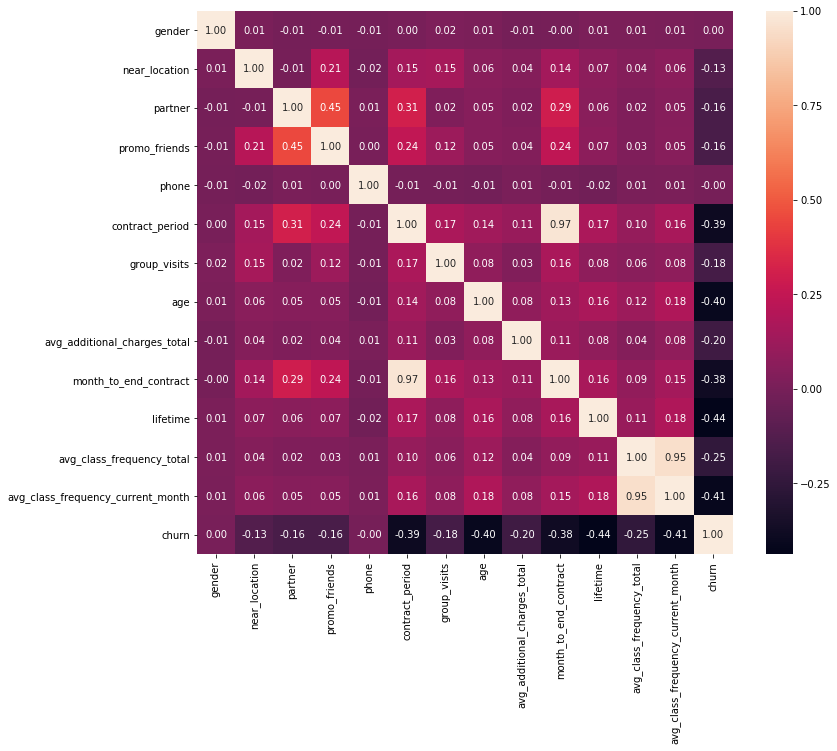

In [11]:
#Построим матрицу корреляций
cm=data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='0.2f')
plt.show()

Из таблицы выделяются мультиколлинеарные признаки- срок до окончания текущего действующего абонемента с длительностью текущего действующего абонемента, а также средняя частота посещений в неделю за предыдущий месяц и средняя частота посещений в неделю за все время с начала действия абонемента. У половой принадлежности и наличия телефонов нулевая или отрицательная корреляция.
Обзвоны не решают проблем.

### Построение модели прогнозирования оттока пользователей

In [12]:
X=data.drop('churn', axis=1)
y=data['churn']

In [13]:
#логистической регрессией
# разделим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=0)

In [14]:
# зададим алгоритм для нашей модели
model = LogisticRegression() 

In [15]:
# обучим модель
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:,1]

In [17]:
# выведим все метрики для полученного прогноза
print('Accuracy-Доля правильных ответов: {:.2f}'.format(accuracy_score(y_test, predictions) ))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, predictions)))

Accuracy-Доля правильных ответов: 0.93
Precision: 0.89
Recall: 0.84
F1: 0.87


In [18]:
#случайным лесом
# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [19]:
# Преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [20]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state=0) 
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [21]:
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

In [22]:
# выведим все метрики для полученного прогноза
print('Accuracy-Доля правильных ответов: {:.2f}'.format(accuracy_score(y_test, rf_predictions) ))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))
print('F1: {:.2f}'.format(f1_score(y_test, rf_predictions)))

Accuracy-Доля правильных ответов: 0.92
Precision: 0.88
Recall: 0.83
F1: 0.85


Оценивая метрики accuracy, precision и recall для обеих моделей на валидационной выборке можно сказать что модель логистической регрессии показала себя лучше 

### Кластеризация пользователей

In [23]:
# стандартизируем данные
scaler = StandardScaler() # создаём объект класса scaler (нормализатор)
x_sc = scaler.fit_transform(data.drop(columns = ['churn'])) # обучаем нормализатор и преобразуем набор данных 

In [24]:
#Постром матрицу расстояний функцией linkage() на стандартизованной матрице признаков
linked = linkage(x_sc, method = 'ward') 

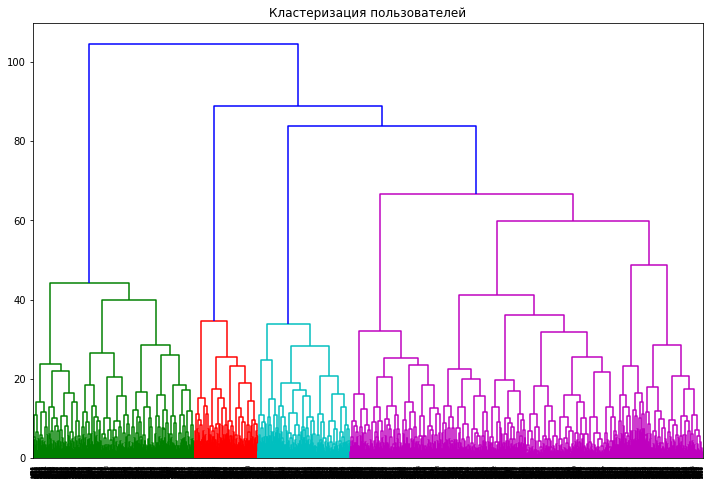

In [25]:
plt.figure(figsize=(12,8))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация пользователей')
plt.show() 

 На основании дендрограммы можно визуально оценить, сколько кластеров должно быть, здесь можно выделить 5 кластеров

In [26]:
#Обучиv модель кластеризации на основании алгоритма K-Means
# задаём модель k_means с числом кластеров 5
km = KMeans(n_clusters = 5, random_state=0)

In [27]:
# прогнозируем кластеры для наблюдений 
labels = km.fit_predict(x_sc)

In [28]:
# сохраняем метки кластера в поле нашего датасета
data['clusters'] = labels

In [29]:
#Посмотриv на средние значения признаков для кластеров
cluster=data.groupby('clusters',as_index=False).mean()
cluster

,clusters,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,0,0.502473,0.959446,0.783383,0.574679,1.000000,10.884273,0.543027,29.980218,160.706969,9.950544,4.738872,1.983305,1.976225,0.027695
1,1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,4,0.560335,0.976105,0.356033,0.229391,0.998805,2.665472,0.473118,30.127838,161.724258,2.455197,4.896057,2.851531,2.849473,0.068100


Оценив средние значения признаков для кластеров можно сказать что 0 и 4 кластеры можно отнести к "хорошим", хотя у них есть определенные различия в средних в partner,contract_period, и срок до окончания текущего действующего абонемента у 0 кластера велик, эти клиенты являются постоянными, а также не скупятся на другие услуги фитнес-центра: кафе, спорт-товары, косметический и массажный салон. 1 кластер можно назвать "средним"- он по показателям не сильно отличается от хороших кластеров, но денег на сопутствующие процедуры тратят меньше.
2 и 3 кластеры можно отнести к "плохим",  факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)- минимальный, возможно если бы их туда привел какойто знакомый и составил компанию-они бы продолжили свою спортивную жизнь(хотя не факт), длительность текущего действующего абонемента тоже минимальна(возможно брали абонемент на месяц или 3-похудеть к лету, и решили попробовать новую жизнь с Нового года)

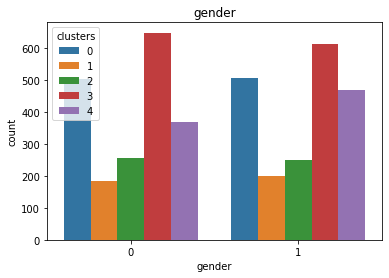

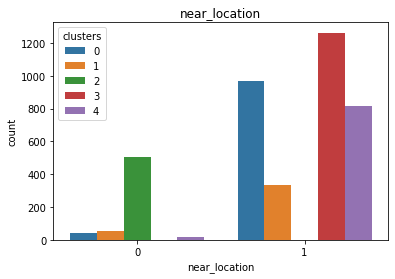

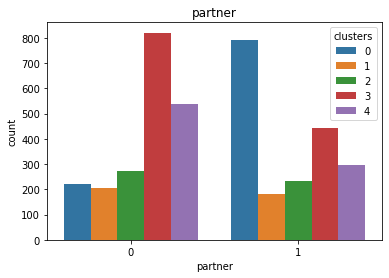

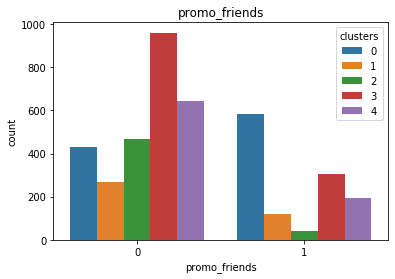

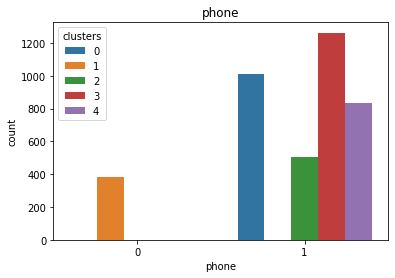

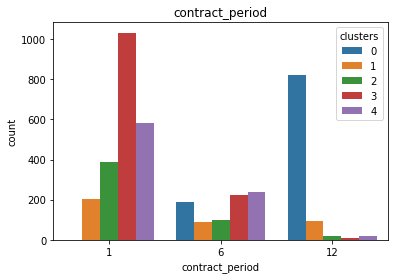

In [30]:
#Построим распределения признаков для кластеров
list = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period']  # создаем список
for item in list:
    sns.countplot(x=data[item], hue='clusters', data=data)
    plt.title(item)
    plt.show()

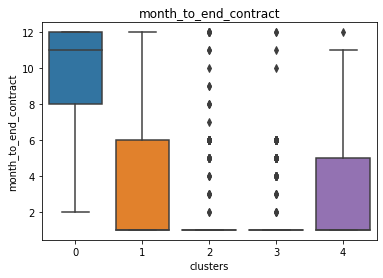

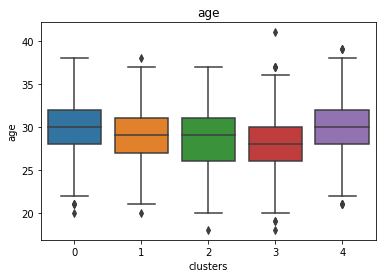

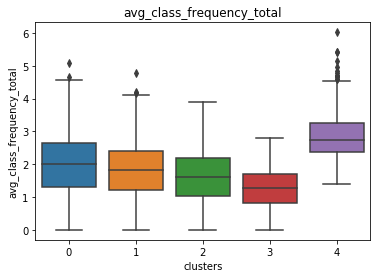

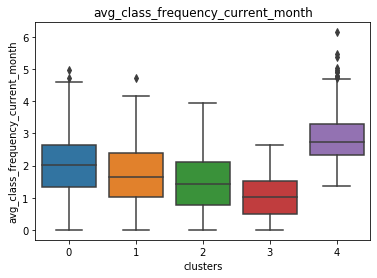

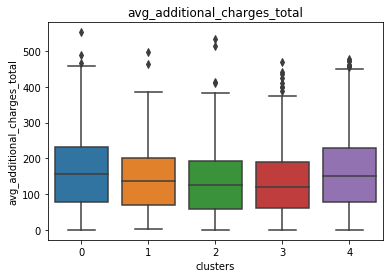

In [31]:
list = ['month_to_end_contract', 'age', 'avg_class_frequency_total', 'avg_class_frequency_current_month', 'avg_additional_charges_total']  # создаем список
for item in list:
    sns.boxplot(x='clusters', y=data[item], data=data)
    plt.title(item)
    plt.show()

In [32]:
cluster['part']=cluster['churn']/cluster['churn'].sum()*100
cluster.T

,0,1,2,3,4
clusters,0.000000,1.000000,2.000000,3.000000,4.000000
gender,0.502473,0.522078,0.495050,0.485737,0.560335
near_location,0.959446,0.862338,0.000000,1.000000,0.976105
partner,0.783383,0.470130,0.463366,0.350238,0.356033
promo_friends,0.574679,0.306494,0.079208,0.240095,0.229391
phone,1.000000,0.000000,1.000000,1.000000,0.998805
contract_period,10.884273,4.787013,2.352475,1.948494,2.665472
group_visits,0.543027,0.425974,0.215842,0.341521,0.473118
age,29.980218,29.301299,28.477228,28.167987,30.127838
avg_additional_charges_total,160.706969,143.957664,135.457501,131.622204,161.724258


В процентном соотношении самый большой отток у 3 кластера-почти 40%, следом идет 2 кластер с оттоком 34%. Средний 1 кластер с оттоком в 20%. Лучшие показатели у 4 и 0 кластеров 5% и 2% соответственно 

# Вывод

Из представленных данных можно выделить два позитивных кластера, которые необходимо эффективно мотивировать. Это может быть как разработка бонусных программ связанных с привлечением коллег и друзей, семейные занятия и групповые мероприятия. Целесообразность маркетинговых акций может быть эффективна также и в других кластерах, однако продолжительность и заинтересованность клиентов напрямую влечет приток взаимосвязанных пользователей.
Клиентов с минимальными сроками посещений также возможно замотивировать на посещения, используя преимущества длинных программ, но на особых индивидуальных условиях. Так как критерии устойчивости использования услуг фитнесс центра выявлены в позитивных кластерах, имеется необходимость донесения этих преимуществ в группы оттока.
Группы оттока также неоднородны, для них необходимо ранжирование и кластеризация в целях индивидуального донесения преимуществ.